In [65]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [ ]:
### Function fire_timeline

def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

def get_lt(lt_string = "Lt_CA_Boreal_"):
    files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/" + lt_string +"*.csv")
    return(concat_subsets(files))


def fire_timeline(fireID, 
                  lt,
                  year = '2023',
                  path_region="QuebecGlobalNRT_3571" , 
                  check_last = False, 
                  FWI_source = "station" ):
    
    '''
    '''
    
    ## Read in the largefire file of the fireID
    try:
        fr = fv.load_large_fire(fireID, year = year, path_region= path_region, s3_path = True) ## Cluster of 2 fires. 
    except Exception as e:
        print("Fire ID cannot be opened:",fireID)
        print(e)
        return(None)
        ## TO DO Filter? 
            ## VIIRS Static source filter?
            ## WUI filter? 
            
    oldest_perim = fr[fr.t == fr.t.max()]
    first_perim = fr[fr.t == fr.t.min()]
    
    if(check_last == True):
        oldest_perim.t = oldest_perim.t.astype("str")
        m = oldest_perim.explore()
        return(m)
        
    fr = fr.to_crs("3571")
    
    
     ## Subset lightning by time and space
    
    ## TO DO: Figure out which CA ecoregion/province the fire is in and subset lighting by that? 
    #print("Not yet subseting spatially beyond quebec. Assuming quebec bounding box")
    
    min_threshold = fr.t.astype('datetime64[ns]').min() - timedelta(days = 10)
    possible_lt = lt[lt.t <= fr.t.min()]
    possible_lt = possible_lt[possible_lt.t >= min_threshold]

    first_perim.geometry = first_perim.buffer(750*2) ## Two viirs pixels???
    join_lt = gpd.sjoin(possible_lt, first_perim, predicate = 'within', how = "inner")
    join_lt["no_strikes_in_time"] = False
    
    if (len(possible_lt == 0)):
        join_lt["no_strikes_in_time"] = True
    
    if (len(join_lt[join_lt.InterCloud.isna()].InterCloud) == len(join_lt.InterCloud)):
        join_lt["num_candidates"] = 0
        join_lt["num_strikes"] = len(possible_lt)
        join_lt["num_strikes_10_days"] = len(possible_lt)
    else:
        ## Extract "denominator" or the # of strikes from same period
        denominator = possible_lt[possible_lt.t >= join_lt.t_left.min()]
        denominator = denominator[denominator.t <= join_lt.t_left.max()]
        join_lt["num_candidates"] = len(join_lt)
        join_lt["num_strikes"] = len(denominator)
        join_lt["num_strikes_10_days"] = len(possible_lt)
        
    ## Get distance to individuals ignitions
    # fr["perim_rank"] = fr.t.rank()
    # first_geom = fr[fr.perim_rank == 1].geometry
    # first_geom = first_geom.iloc[0]
    # num_starts = len(first_geom.geoms)
    # for i in range(0, num_starts):
    #     join_lt["dist_start_" + str(i)] = join_lt.distance(first_geom.geoms[i].centroid)
    #     print(fr[fr.perim_rank == 1].to_crs("4326").geometry.iloc[0].geoms[i].centroid)
        
    ## Rank candidate by distance
    # range_geoms = list(range(0, num_starts))
    # string = "dist_start_"
    # columns_dists = [string + str(x) for x in range_geoms]
    # top = len(join_lt) * 1 # Top 100%. Could cut to smaller range
    # dist_bool = join_lt[columns_dists].rank() <= top ## NEED a max distance cutoff. 
    # join_lt["candidate"] = dist_bool.any(axis = 1)
    
    ## Get raw VIIRS pixel timing
    date_string = fr.t.astype("datetime64[ns]").max().strftime("%Y%m%d%p")
    print(date_string)
    raw_obs_times = fv.raw_pixel_times(int(fireID), date_string = date_string, path_region = path_region)
    raw_obs_times = raw_obs_times.reset_index()
    
    ## get station data
    if(FWI_source == "station"):
        print("Assuming Single Quebec Station. 718270-99999.")
        st = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/718270-99999.linear.HourlyFWIFromHourlyInterpContinuous.csv") ## Corrected record from Robert
        st.HH = st.HH.astype("int")
        st.YYYY = st.YYYY.astype("int")
        st.MM = st.MM.astype("int")
        st.DD = st.DD.astype("int")
        st = fv.date_convert(st)
        
        st_rm = st[["time", "TEMP_C", 'RH_PERC', 'VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI',
       'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD',
       'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS']]
        st_rm = st_rm.rename(columns = {"time":"t"})
        #### Subset station data by time. 
        st_rm = st_rm[st_rm.t >= min_threshold]
        st_rm = st_rm[st_rm.t <= fr.t.max()]
        
    else:
        #print("No other FWI extraction method ready. Sorry. ")
        raise Exception("No other FWI extraction method ready. Sorry. ")
    
    ## Do merging of all dfs 
    foo = join_lt[["InterCloud", "t_left", "lat_left", "lon_left", "current_mag", "error_elps", "num_station", "num_candidates", "num_strikes", "num_strikes_10_days", "no_strikes_in_time"]]
    foo = foo.rename(columns = {"t_left":"t", "lat_left":"lat", "lon_left":"lon"})
    foo.t = foo.t.astype('datetime64[ns]')
    raw_obs_times = raw_obs_times.rename(columns={"count": "viirs_pix_count"}) 
    raw_obs_times.t = raw_obs_times.t.astype("datetime64[ns]")
    merged = foo.merge(raw_obs_times, on = ["t"], how = "outer")
        
    fr_rm = fr.rename(columns = {"lat":"lat_centroid", "lon":"lon_centroid"})
    fr_rm.t = fr_rm.t.astype("datetime64[ns]")
    merged = merged.merge(fr_rm, on = ["t"], how = "outer")
    
    merged = merged.merge(st_rm, on = ["t"], how = "outer")
    merged["fireID"] = fireID
    
    ## Find temporal thresholds
    
    first_ig = merged[~merged.InterCloud.isna()].t.min()
    last_ig = merged[~merged.InterCloud.isna()].t.max()
    first_detection = merged[~merged.viirs_pix_count.isna()].t.min()

    
    merged["pre_fire"] = ((merged.t >= last_ig) & (merged.t <=  first_detection)) #### first_ig better????????????
    
    ### TODO:  Growht threshold
    return(merged)
    

def lf_ids(year = None, regnm = 'BOREAL_NRT_3571_DPS'):
    
    diroutdata = "s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/"

    if year == None:
        year = date.today().year

    if diroutdata.startswith("s3://"):
        # Can't use glob for S3. Use s3.ls instead.
        import s3fs
        s3 = s3fs.S3FileSystem(anon=False)
        s3path = os.path.join(diroutdata, regnm, str(year), "Largefire")
        fnms = [f for f in s3.ls(s3path)]


    fnms.sort()
    ids = []
    for f in fnms:
        fnm_lts = os.path.basename(f) 
        one_id = fnm_lts[1:-11]
        ids.append(one_id)
    tmp_ids = pd.DataFrame(ids, columns=["ids"])
    tmp_ids = tmp_ids.ids.unique()
    return(tmp_ids)

def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return(unique_list)

def get_listed_ids(quebec_stats):
    newlist = [x.strip('][\n').split(' ') for x in quebec_stats.fireID.unique()]
    newlist = list(chain(*newlist))
    newlist = [x.replace('\n', ' ') for x in newlist]
    newlist = unique(newlist)
    return(newlist)

# def lf_ids(regnm = 'BOREAL_NRT_3571_DPS', year = None):
    
#     diroutdata = "s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/"

#     if year == None:
#         year = date.today().year

#     if diroutdata.startswith("s3://"):
#         # Can't use glob for S3. Use s3.ls instead.
#         import s3fs
#         s3 = s3fs.S3FileSystem(anon=False)
#         s3path = os.path.join(diroutdata, regnm, str(year), "Largefire")
#         fnms = [f for f in s3.ls(s3path)]
#     else:
#         fnms = glob(os.path.join(diroutdata, regnm, str(year), "Largefire"))

#     if len(fnms) > 0:
#         #print("yeah")
#         fnms.sort()
#         ids = []
#         for f in fnms:
#             fnm_lts = os.path.basename(f) ## Can't work, no ordering
#             ids.append(fnm_lts[1:-11])

#     ids = unique(ids)
#     return(ids)
    

In [67]:
lt = get_lt() 

In [68]:
lt = gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt.lon, lt.lat), crs=4326) #4674
prov = fv.ca_prov()
lt = lt.sjoin(prov)
lt = lt.to_crs("3571")
## SUBSET lt to quebec
lt = lt[lt.prov_name_en == 'Quebec']

In [69]:
## SUBSET lt to quebec
#lt = lt[lt.prov_name_en == 'Quebec']

In [70]:
lt = lt[['InterCloud', 't', 'lat', 'lon', 'current_mag',
       'multiplicity_0', 'accr', 'error_elps', 'num_station', 'geometry']]

In [5]:
#tmp = fire_timeline('615', lt = lt, path_region="QuebecGlobalNRT_DPS") #QuebecGlobalNRT_3571

In [6]:
# date_range = pd.date_range(start = "2023-05-01 12:00:00", end = "2023-07-01 12:00:00", freq="12H")
# #date_range_format = datetime.strptime(date_rage, 
# date_snap = date_range.strftime("%Y%m%d%p")

In [71]:
## Get IDs. These IDs come from csvs made by old_shared/fire_weather_vis/Lightning_analysis/snap_prov_lightning.ipynb
# by going through the snapshot files, doing a spatial join, and collecting IDs. 

files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats//boreal_snapstats*.csv")

fire_stats = concat_subsets(files)

fire_stats.t.max()

### Subsetting fire stats by largefire record, so don't waste time looking for IDs that we haven't got yet. Wait, not worth it, size a bigger thing anyway.
#fire_stats = fire_stats[fire_stats.t < "2023-07-20 12:00:00"]

#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

Timestamp('2023-08-30 12:00:00')

In [72]:
quebec_stats = fire_stats[fire_stats.prov_name_en == "Quebec"]

tmp_list = get_listed_ids(quebec_stats)

In [73]:
ids_lf = lf_ids()

tmp_list = list(set(tmp_list).intersection(ids_lf))
#tmp_list

In [62]:
from datetime import date
str(date.today().strftime("%Y%m%d"))

'20231108'

In [98]:
#ids = ['12641', '12690','10896','9346']

ids = tmp_list

max_t = "maxT" + str(fire_stats.t.max().strftime("%Y%m%d")) + "_"
min_t = "minT" + str(fire_stats.t.min().strftime("%Y%m%d")) + "_"
print(max_t)
print(min_t)

maxT20230830_
minT20230301_


In [ ]:
year = '2023'
path_region= "BOREAL_NRT_3571_DPS" 
check_last = False 
FWI_source = "station" 

fires = pd.DataFrame()
for n,i in enumerate(ids, start = 0):
    try:
        foo = fire_timeline(i, lt = lt, year = year, path_region= path_region, check_last = False, FWI_source = FWI_source)
    except Exception as e:
        print("Error at ID: ",i)
        print(e)
        continue
    ## Extract the period between 
    fires = pd.concat([fires, foo])
    #print(fires)
        #fr_pd = pd.DataFrame(fires, columns=["lat", "lon", "farea", "data_source"])
    fires.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/"+"fire_stats_only_718270-99999_" +min_t + max_t + path_region + FWI_source + str(date.today().strftime("%Y%m%d"))+  ".csv")

['F8569']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230626AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F13125']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230711AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8562']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230605PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F9187']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F12688']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F13140']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230711AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10972']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8649']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230725PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F9837']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F11302']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230715PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F11357']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230701AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F13275']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8553']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230626PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8671']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230624PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F13042']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230714PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F9346']
20230607AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8570']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230730PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10140']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10946']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230622AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8244']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8635']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230612AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10713']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8677']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230620AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F12640']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10547']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F9509']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230613AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F9188']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10056']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230717AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F12197']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230705AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F9267']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8640']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230605AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F8552']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F12603']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230715AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Error at ID:  12603
[Errno 107] Transport endpoint is not connected
['F8495']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  8495
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F8881']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625AM
Error at ID:  8881
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230625AM.pkl'
['F12596']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716AM
Error at ID:  12596
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230716AM.pkl'
['F11603']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230730PM
Error at ID:  11603
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230730PM.pkl'
['F12656']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12656
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F8563']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230622PM
Error at ID:  8563
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230622PM.pkl'
['F12154']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230730PM
Error at ID:  12154
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230730PM.pkl'
['F12595']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12595
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F12375']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12375
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F12467']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM
Error at ID:  12467
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230726AM.pkl'
['F8866']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230626AM
Error at ID:  8866
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230626AM.pkl'
['F12138']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230730PM
Error at ID:  12138
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230730PM.pkl'
['F10714']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230715PM
Error at ID:  10714
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230715PM.pkl'
['F13135']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230712PM
Error at ID:  13135
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230712PM.pkl'
['F9612']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM
Error at ID:  9612
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230703PM.pkl'
['F10887']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230622PM
Error at ID:  10887
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230622PM.pkl'
['F8577']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230626PM
Error at ID:  8577
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230626PM.pkl'
['F8621']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM
Error at ID:  8621
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230726AM.pkl'
['F14729']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  14729
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F10481']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230711AM
Error at ID:  10481
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230711AM.pkl'
['F13668']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230714AM
Error at ID:  13668
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230714AM.pkl'
['F12151']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM
Error at ID:  12151
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230726AM.pkl'
['F12325']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12325
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F12199']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM
Error at ID:  12199
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230726AM.pkl'
['F9266']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM
Error at ID:  9266
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230703PM.pkl'
['F12144']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726PM
Error at ID:  12144
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230726PM.pkl'
['F10749']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716PM
Error at ID:  10749
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230716PM.pkl'
['F13395']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230714PM
Error at ID:  13395
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230714PM.pkl'
['F10789']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230623PM
Error at ID:  10789
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230623PM.pkl'
['F14490']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  14490
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F13165']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230711AM
Error at ID:  13165
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230711AM.pkl'
['F8867']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM
Error at ID:  8867
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230625PM.pkl'
['F11221']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230720PM
Error at ID:  11221
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230720PM.pkl'
['F8538']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230623AM
Error at ID:  8538
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230623AM.pkl'
['F8612']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230626AM
Error at ID:  8612
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230626AM.pkl'
['F8555']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230626AM
Error at ID:  8555
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230626AM.pkl'
['F12200']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM
Error at ID:  12200
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230726AM.pkl'
['F12160']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230728PM
Error at ID:  12160
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230728PM.pkl'
['F8928']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM
Error at ID:  8928
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230625PM.pkl'
['F12641']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12641
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F8746']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230603AM
Error at ID:  8746
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230603AM.pkl'
['F8877']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM
Error at ID:  8877
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230625PM.pkl'
['F10013']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM
Error at ID:  10013
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230703PM.pkl'
['F12690']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12690
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F8904']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230624PM
Error at ID:  8904
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230624PM.pkl'
['F8642']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230622AM
Error at ID:  8642
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230622AM.pkl'
['F11355']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230731AM
Error at ID:  11355
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230731AM.pkl'
['F8732']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625AM
Error at ID:  8732
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230625AM.pkl'
['F10872']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716PM
Error at ID:  10872
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230716PM.pkl'
['F12202']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230704AM
Error at ID:  12202
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230704AM.pkl'
['F12639']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM
Error at ID:  12639
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230803AM.pkl'
['F8723']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230629PM
Error at ID:  8723
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230629PM.pkl'
['F8737']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230603AM
Error at ID:  8737
[Errno 107] Transport endpoint is not connected: '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230603AM.pkl'
['F10537']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F10577']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F12691']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230714AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.
['F12652']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F10792']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230624AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F12642']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230711PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8776']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230627AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8630']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230624PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F12164']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8551']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8572']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8627']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230625PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8631']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230605PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F8632']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230612PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F9275']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230716PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F12276']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230726AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F12158']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230703AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F12381']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F10147']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230703PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F10546']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230622AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F10435']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230715AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

Assuming Single Quebec Station. 718270-99999.
['F10286']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


20230802PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930:

In [84]:
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/fire_stats_only_718270-99999_minT2023-03-01_12:00:00_maxT2023-08-30_12:00:00_BOREAL_NRT_3571_DPSstation20231101.csv"

fires = pd.read_csv(path)
fires.columns

Index(['Unnamed: 0', 'InterCloud', 'lat', 'lon', 'current_mag', 'error_elps',
       'num_station', 'num_candidates', 'num_strikes', 'num_strikes_10_days',
       'no_strikes', 't', 'viirs_pix_count', 'fireID', 'n_pixels',
       'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration', 'pixden',
       'meanFRP', 'geometry', 'lon_centroid', 'lat_centroid', 'TEMP_C',
       'RH_PERC', 'VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM',
       'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP',
       'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED',
       'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS', 'pre_fire'],
      dtype='object')

In [60]:
#fire_timeline(fireID = '13165' , lt = lt, year = year, path_region= path_region , check_last = False, FWI_source = FWI_source)

In [ ]:
# "20230720PM"

# raw_obs_times = fv.raw_pixel_times(int(12641), date_string = "20230720PM", path_region = "BOREAL_NRT_3571_DPS")

In [ ]:
# # import pickle

# fireID = '12641'
# file = open('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230720PM.pkl', 'rb')

# # dump information to that file
# data = pickle.load(file)

# # close the file
# file.close()

# fireID = int(fireID)

# times = []
# for i in range(0, len(data.fires[fireID].pixels)):
#     #print(i)
#     times.append(data.fires[fireID].pixels[i].datetime)

In [ ]:
#len(data.fires)

In [ ]:
#len(data.fires[fireID].pixels)

In [22]:
fires.fireID.unique()

array([ 8677,  8747, 12156,  8556,  9844, 12652,  9266, 12155, 13140,
       10718, 12687, 12138, 12642,  8641, 11355, 12329, 10069, 11265,
       10714, 10972,  8756, 10809,  8928, 14490,  8774,  9612,  8640,
       12197, 12655,  8502,  8720, 10749,  9267, 13135, 12200,  8723,
        8244,  8610,  9200, 12154, 11713, 10522, 12381, 13021,  8630,
        8555,  8881, 12604, 12692,  8627,  8867,  8570, 10286, 13039,
        8880, 13042, 12151,  8636,  8501, 12202, 10538, 10872,  8872,
        8620,  8639,  8495,  8538, 12207, 12756, 11603,  8619,  8631,
        8679,  8534,  8536, 12325, 13906, 12656, 10792, 12653, 10406,
       12385, 13165, 12145, 12146,  8671,  8622, 10056, 10577, 12153,
       10546, 13269, 12160, 12164,  8746,  9188,  8642,  8643,  8629,
        8737, 10976, 10946,  8562, 10547, 10806, 12159,  8776, 13275,
        8866,  9837,  8559,  8551,  8920, 12158,  8632,  9275,  8628,
        8879, 11302, 10750,  8865,  8645, 10713, 12596,  8569, 12595,
       12147,  8578,

In [23]:
#new_fire = fires.groupby("fireID")

In [24]:
# #group_first_ig = fires[~fires.InterCloud.isna()].groupby("fireID").t.min() #.reset_index()
# group_first_ig

In [25]:
# group_first_detect = fires[~fires.viirs_pix_count.isna()].groupby("fireID").t.min() #.reset_index()
# group_first_detect

In [26]:
# smol["pre_fire"] = ((smol.t >= last_ig) & (smol.t <=  first_detection))

In [ ]:
# fires.columns

In [ ]:
# fires.groupby('fireID').t["Inter"]

In [28]:
#fires.fireID.isin(tmp_list)
#len(fires.fireID.unique())/len(tmp_list)

In [24]:
#smol = fires[fires.fireID == '12375']

In [25]:
#subset_group_first_detect = group_first_detect[group_first_detect.index.isin(group_first_ig.index)]

In [26]:
#fires.groupby('fireID').t >= group_first_ig

2023-07-05 10:16:09.925000
2023-07-05 10:25:15.219000
2023-07-05 17:45:00
2023-07-05 12:00:00


/tmp/ipykernel_177/162921546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smol["pre_fire"] = ((smol.t >= last_ig) & (smol.t <=  first_detection)) #### first_ig better????????????


In [27]:
fires.columns

Index(['InterCloud', 'lat', 'lon', 'current_mag', 'error_elps', 'num_station',
       't', 'viirs_pix_count', 'fireID', 'n_pixels', 'n_newpixels', 'farea',
       'fperim', 'flinelen', 'duration', 'pixden', 'meanFRP', 'geometry',
       'lon_centroid', 'lat_centroid', 'TEMP_C', 'RH_PERC', 'VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI',
       'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH',
       'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW',
       'OBSMINUTEDIFF_VIS', 'pre_fire'],
      dtype='object')

In [ ]:
met_cols = ['TEMP_C', 'RH_PERC', 'VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI',
       'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH']

In [45]:
fires.num_strikes.unique()

array([       nan, 1.0000e+00, 7.2800e+02, 7.0000e+00, 1.5730e+03,
       5.1800e+02, 2.0000e+00, 2.0210e+04, 2.0000e+01, 6.1600e+02,
       1.9800e+02, 1.0220e+03, 1.4980e+03, 2.4600e+02, 2.2700e+02,
       3.1620e+03, 1.7480e+03, 1.4736e+04, 8.9000e+01, 1.7220e+03,
       1.3800e+02, 5.0000e+01, 2.5300e+02, 1.4000e+01, 3.4800e+02,
       7.0900e+02, 9.4000e+01, 1.4892e+04, 2.7740e+03, 1.4900e+02,
       1.0150e+04])

In [42]:
### Get Distribution of times from "ignition" to first detection



#percent_no_candidate_ignition = (len(fires.fireID.unique()) - len(fires[~fires.InterCloud.isna()].fireID.unique()))/ len(fires.fireID.unique())
percent_no_candidate_ignition = len(fires[fires.no_strikes == True].fireID.unique())/len(fires.fireID.unique())

print("Percent no ignitions: ", percent_no_candidate_ignition)
print("No ignitions", len(fires[fires.no_strikes == True].fireID.unique()))
print("No ignitions by candidates", len(fires[fires.num_candidates == 0].fireID.unique()))
print("Candidate ignitions", len(fires[fires.num_candidates > 0].fireID.unique()))
print("Total", len(fires.fireID.unique()))

group_first_detect = fires[~fires.viirs_pix_count.isna()].groupby("fireID").t.min().reset_index()
group_first_detect = group_first_detect.rename(columns={"t":"first_detect"})
#group_first_detect


group_last_ig = fires[~fires.InterCloud.isna()].groupby("fireID").t.max().reset_index()
group_last_ig = group_last_ig.rename(columns={"t":"last_ig"})

time_dist = group_last_ig.merge(group_first_detect, on = ["fireID"], how = "outer")
time_dist = time_dist.dropna()
time_dist
# group_first_ig

time_dist["time_diff"] = time_dist.first_detect.astype("datetime64[ns]") - time_dist.last_ig.astype("datetime64[ns]")

Percent no ignitions:  0.2897196261682243
No ignitions 62
No ignitions by candidates 0
Candidate ignitions 62
Total 214


In [36]:
time_dist["time_diff"].astype('timedelta64[h]').plot.hist(title = "Hours from ignition to First VIIRS detection")
print(len(time_dist))
print(len(tmp_list))
print(len(time_dist)/len(tmp_list))

print(max_t)
print(min_t)
print(min(time_dist))

62


NameError: name 'tmp_list' is not defined

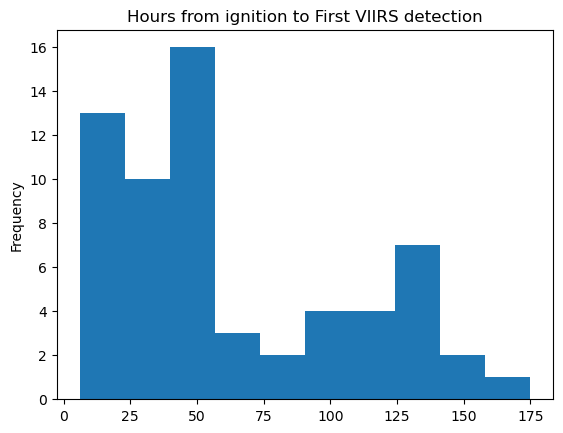

In [46]:
# fr = fr.sort_values(by = ['t'])

# fig, ax = plt.subplots()
# ax.fill_between(upper.index, upper.FWI.rolling(1).mean(), lower.FWI.rolling(5).mean(), 
#                 facecolor='grey', 
#                 alpha=0.2,
#                 label= "95th Percentile")
# ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(1).mean(), mid_lower.FWI.rolling(5).mean(), 
#                 facecolor='grey', 
#                 alpha=0.4,
#                 label= "25th Percentile")
# ax.plot(mean_quant.index, mean_quant.FWI.rolling(1).mean(), 
#         color = "black",
#         label= "Historic Mean Per Day")
# ax.plot(st[(st.time >= "2023-05-01")].time.astype('datetime64[ns]'), st[(st.time >= "2023-05-01")].FWI)
# ax.set_ylabel("Fire Weather Index")
# ax.set_title("2023 Fire Weather Index (FWI) for La Grande Rivière, Quebec, Canada (WMO ID 718270)")
# #ax.legend()
# ax2 = ax.twinx()
# ax2.scatter(candidate.t_left.astype("datetime64[ns]"), candidate.candidate, color = "purple")
# ax2.set_yticklabels("")
# #ax2.plot(fire_stats.t, fire_stats.num_active_fires, color = "red", label = "Number of Fires in Quebec")
# #ax2.legend(loc = 0.5)
# ax3 = ax.twinx()
# #ax3.spines.right.set_position(("axes", 1.2))
# ax3.plot(fr.t.astype("datetime64[ns]"), fr.farea, color = "red")
# #ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")

# ax4 = ax.twinx()
# ax4.spines.right.set_position(("axes", 1.2))
# ax4.scatter(raw_obs_times.index, raw_obs_times['count'], color = "orange")

# fig.autofmt_xdate()

# # print("First detection: " + str(fr.t.astype("datetime64[ns]").min()) )
# print(candidate.t_left.min())
# print(candidate.t_left.max())

In [85]:
# def gpd_read_file(filename, parquet=False, **kwargs):
#     itry = 0
#     maxtries = 5
#     fun = gpd.read_parquet if parquet else gpd.read_file
#     while itry < maxtries:
#         try:
#             dat = fun(filename, **kwargs)
#             return dat
#         except Exception as e:
#             itry += 1
#             print(f"Attempt {itry}/{maxtries} failed.")
#             if not itry < maxtries:
#                 raise e



# def load_large_fire(fireID, year = "2019", path_region = "WesternUS", layer='perimeter', s3_path = False):
#     '''
#     loads in largefire file based on fireID and layer, then preps it for "explore" by adding centriod data. Currently limited to one year. 
    
#     INPUTS:
        
#         fireID (str): fireID offire of interest. Can be found in gdf files read in by prep_gdf and load_file. Can be selected interactivly form a gdf if use gdf.explore()
#         year (str): Year that fires took place. Default to 2019. Availible options differ by path_region. 
#         path_region (str): This constructs the path that the fires are stored in. WesternUS and CONUS availible. 
#         layer (str): The largefire layer to load. Options are 'perimeter', 'nfplist', 'fireline', and 'newfirepix'. 
#     '''
#     if(s3_path == True):
#         tmp = s3.glob('s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')
#         lf_files =  ["s3://" + t for t in tmp]
    
#     else:
#         lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')
#         #print(lf_files)
#     lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
#     print(lf_ids)
#     largefire_dict = dict.fromkeys(lf_ids)
    
#     for lf_id in lf_ids:
#         most_recent_file = [file for file in lf_files if lf_id in file][-1]
#         largefire_dict[lf_id] = most_recent_file
#     if(s3_path == True):
#         gdf = pd.concat([gpd_read_file(file,layer= layer) for key, file in largefire_dict.items()], 
#                        ignore_index=True)
#     else:
#         gdf = pd.concat([gpd.read_file(file,layer= layer) for key, file in largefire_dict.items()], 
#                        ignore_index=True)
#     gdf = gdf.to_crs('EPSG:4326')
#     gdf['lon'] = gdf.centroid.x
#     gdf['lat'] = gdf.centroid.y
#     return gdf

In [84]:
load_large_fire(fireID = '13165', year = '2023', path_region= "BOREAL_NRT_3571_DPS", s3_path = True)

['F13165']


/tmp/ipykernel_177/4002652227.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_177/4002652227.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


,n_pixels,n_newpixels,farea,fperim,flinelen,...,meanFRP,t,geometry,lon,lat
0,77,77,20.093947,34.028644,31.234218,...,1.906494,2023-07-11,"MULTIPOLYGON (((-78.20751 51.02346, -78.20754 ...",-78.276415,51.03515


In [74]:
fireID = '13165'

s3.glob('s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')

['maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Largefire/F13165_20230711AM']

In [80]:
tmp = s3.glob('s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')

tmp =  ["s3://" + t for t in tmp]

tmp

['s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Largefire/F13165_20230711AM']

In [52]:
fires[["fireID", 't', 'InterCloud', 'num_candidates']][fires.InterCloud.isna()]#.groupby(["fireID", 'InterCloud', 'num_candidates']).t.min()

,fireID,t,InterCloud,num_candidates
0,8677,2023-06-02 18:56:00,NaN,NaN
1,8677,2023-06-03 06:18:00,NaN,NaN
2,8677,2023-06-03 07:09:00,NaN,NaN
3,8677,2023-06-03 07:58:00,NaN,NaN
4,8677,2023-06-03 16:56:00,NaN,NaN
...,...,...,...,...
149365,8624,2023-07-02 19:00:00.000,NaN,NaN
149366,8624,2023-07-02 20:00:00.000,NaN,NaN
149367,8624,2023-07-02 21:00:00.000,NaN,NaN
149368,8624,2023-07-02 22:00:00.000,NaN,NaN


In [48]:
fires.columns

Index(['Unnamed: 0', 'InterCloud', 'lat', 'lon', 'current_mag', 'error_elps',
       'num_station', 'num_candidates', 'num_strikes', 'num_strikes_10_days',
       'no_strikes', 't', 'viirs_pix_count', 'fireID', 'n_pixels',
       'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration', 'pixden',
       'meanFRP', 'geometry', 'lon_centroid', 'lat_centroid', 'TEMP_C',
       'RH_PERC', 'VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM',
       'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP',
       'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED',
       'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS', 'pre_fire'],
      dtype='object')

In [ ]:
possible_lt

In [83]:
fires[fires.fireID == '9346'][["fireID", "t", "num_candidates", "pre_fire", "InterCloud"]]

,fireID,t,num_candidates,pre_fire,InterCloud
0,9346,2023-06-01 20:51:00.052,8.0,False,0
1,9346,2023-06-01 20:51:00.052,8.0,False,0
2,9346,2023-06-01 18:36:59.095,8.0,False,0
3,9346,2023-06-01 18:36:59.095,8.0,False,0
4,9346,2023-06-01 21:05:23.436,8.0,True,0
...,...,...,...,...,...
248,9346,2023-06-06 19:00:00.000,NaN,True,NaN
249,9346,2023-06-06 20:00:00.000,NaN,True,NaN
250,9346,2023-06-06 21:00:00.000,NaN,True,NaN
251,9346,2023-06-06 22:00:00.000,NaN,True,NaN


In [ ]:
has_lt = fires.groupby("fireID").InterCloud.max().reset_index()
has_lt

len(has_lt[has_lt.isna()])

In [ ]:
print(len(has_lt[has_lt.InterCloud.isna()]))

print(len(has_lt[has_lt.InterCloud == 0]))
